5.1 介绍多程序处理

In [1]:
import multiprocessing as mp
import numpy as np
from multiprocessing import queues
from IPython.display import clear_output
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# def square(x): # 将阵列输入此函式后，会传回个别数字的平方结果
#   return np.square(x)

In [3]:
# x = np.arange(64) # 生成内有数字序列的阵列
# print(x)

In [4]:
# mp.cpu_count() # 输出CPU的数量，结果因电脑而不同

In [5]:
# pool = mp.Pool(8) # 建立内含8个程序的多程序池(proccessor pool)
# squared = pool.map(square,[x[8*i:8*i+8] for i in range(8)]) # 使用多程序池的map()，对阵列中的每一个数字呼叫square(),并将结果存入串列中传回
# print(squared)

5.2 用手动方式开启多程序

In [6]:
# def square(i,x,queue):
#   print("In proccess {}".format(i,))
#   queue.put(np.square(x)) # 将输出结果存进queue

In [7]:
# proccess = [] # 建立用来存储不同程序的串列
# queue = mp.Queue() # 建立多程序处理的queue
# x = np.arange(64) # 生成一个数列作为目标数列(内含有0~63的整数)
# for i in range(8): # 开启八条程序，并让他们利用square函数分别处理目标数列中的一部分资料
#   start_index = 8*i
#   proc = mp.Process(target=square,args=(i,x[start_index:start_index+8],queue))
#   proc.start()
#   proccess.append(proc)

# for proc in proccess:
#   proc.join() # 待所有程序执行完毕之后，再将结果传回给主执行绪

# for proc in proccess:
#   proc.terminate() # 终止各个程序

# result = []
# while not queue.empty():
#   result.append(queue.get()) # 将queue内的资料存进results串列，直到资料清空

In [8]:
# print(result)

5.3 分散式 優勢演員評論家模型

In [9]:
# class ActorCritic(nn.Module): # 定義演員評論家模型

#   def __init__(self):
#     super(ActorCritic,self).__init__()
#     self.l1 = nn.Linear(4,25) # 定義模型中各種神經網路的shape
#     self.l2 = nn.Linear(25,50)
#     self.actor_lin1 = nn.Linear(50,2)
#     self.l3 = nn.Linear(50,25)
#     self.critic_lin1 = nn.Linear(25,1)
  
#   def forward(self,x):
#     x = F.normalize(x,dim=0) # 正規化輸入資料
#     y = self.l1(x)
#     y = F.relu(y)
#     y = self.l2(y)
#     y = F.relu(y)

#     a = self.actor_lin1(y)
#     actor = F.log_softmax(a,dim=0) # 演員端輸出遊戲中兩種動作的對數化幾率值

#     c = self.l3(y.detach()) # 將評論家端的節點分離，在經過relu的處理
#     c = F.relu(c)
#     c = self.critic_lin1(c)
#     critic = torch.tanh(c) # 評論家端輸出一個範圍在-1到+1之間的純量的原因將在稍後說明

#     return actor,critic

5.7 執行一場遊戲

In [10]:
# def run_episode(worker_env,worker_model):
#   state = torch.from_numpy(worker_env.env.state).float() # 將環境的狀態資料從Numpy類型轉化為PyTorch張量
#   values,logprobs,rewards = [],[],[] # 建立三個串列，分別用來存儲狀態價值(評論家) 對數化幾率分佈(演員) 以及回饋值
#   done = False
#   j = 0
#   while(done == False): # 除非滿足結束條件，否則遊戲繼續進行
#     j += 1 # 記錄執行步數
#     policy,value = worker_model(state) # 計算狀態價值以及各種可能動作的對數化幾率
#     values.append(value) # 將當前的狀態價值加入列表
#     logits = policy.view(-1) # 呼叫view()函式將對數化幾率偏平化成向量
#     action_dist = torch.distributions.Categorical(logits=logits) # 创建以参数logits为标准的类别分布
#     action = action_dist.sample() # 參考演員所提供的對數化幾率來選擇動作
#     logprob_ = policy.view(-1)[action] # 得到所選擇動作的對數化幾率
#     logprobs.append(logprob_) # 將所選擇動作的對數化幾率存入列表
#     state_,_,done,info = worker_env.step(action.detach().numpy()) # 嘗試執行一下所選擇的動作
#     state = torch.from_numpy(state_).float() # 將下一狀態獲取到，並轉化為numpy數組 
#     if done : # 如果遊戲結束
#       reward = -10 # 如果某一個動作造成遊戲結束，則將回饋值設置為-10，並且重置環境
#       worker_env.reset()
#     else:
#       reward = 1.0 # 如果成功保持倒立擺站立，那麼就加回饋值1
#     rewards.append(reward) # 將局部的回饋值添加至列表，用來觀察整體的回饋值變化情況
#   return values,logprobs,rewards,len(rewards) # 返回的最後一項是倒立擺保持平衡的時間步數

5.6 計算並最小化損失

In [11]:
# def update_params(worker_opt,values,logprobs,rewards,clc=0.1,gamma=0.95):
#   '''設定一個clc參數來控制演員損失和評論家損失的影響力'''
#   rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) # 將rewards陣列中的元素順序顛倒，以方便計算折扣回報值陣列
#   logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1) # 將logprobs陣列中的元素順序顛倒，以方便計算折扣回報值陣列
#   values = torch.stack(values).flip(dims=(0,)).view(-1) # 將values陣列中的元素順序顛倒，以方便計算折扣回報值陣列

#   Returns = []

#   ret_ = torch.Tensor([0])
#   for r in range(rewards.shape[0]): # 使用順序顛倒的回饋值來計算每一步的回報值，並將結果存入Returns陣列中
#     ret_ = rewards[r] + gamma*ret_
#     Returns.append(ret_)
  
#   Returns = torch.stack(Returns).view(-1)
#   Returns = F.normalize(Returns,dim=0) # 將Returns陣列中的製作正規化處理

#   actor_loss = -1*logprobs*(Returns - values.detach()) # 將value張量的節點從運算圖中分離(用之前講的detach()),並計算演員的損失

#   critic_loss = torch.pow(values-Returns,2) # 計算評論家的損失

#   loss = actor_loss.sum() + clc*critic_loss.sum() # 將演員的損失與評論家的損失加起來，變成總損失 注意 我們是用clc參數來降低評論家損失的影響

#   loss.backward()
#   worker_opt.step()
#   return actor_loss,critic_loss,len(rewards)

5.6 主要訓練迴圈

In [12]:
# def worker(t,worker_model,counter,params):
#   worker_env = gym.make("CartPole-v1")
#   worker_env.reset()
#   worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters()) # 每條程序有獨立運行的環境和優化器，但共享模型參數
#   worker_opt.zero_grad()

#   for i in range(params["epochs"]):
#     worker_opt.zero_grad()
#     values,logprobs,rewards,length = run_episode(worker_env,worker_model) # 呼叫run_episode()來執行一場遊戲並收集資料(該函式的定義見5.7)
#     actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards) # 使用所收集的資料來更新神經網路參數(該函式的定義見5.8)
    
#     counter.value = counter.value + 1 # counter是一個全域計數器，被所有程序共享

#     if (i%10==0): # 印出當前的訓練進度
#       print(i)
#       print(len(rewards))
#       clear_output(wait=True)
    
#     buffer.put(length) # 將遊戲的長度存進buffer中

5.5 分散式訓練

In [13]:
# if __name__ == '__main__':

#   MasterNode = ActorCritic() # 建立一個共享全域的演員-評論家模型
#   MasterNode.share_memory() # share_memory()允許不同程序共用一組模型參數(無需複製模型節省空間)

#   processes = [] # 用來存儲不同程序的實例
#   params = {
#       'epochs':500, # 進行500次訓練
#       'n_workers':7 # 設定程序數目為7
#   }

#   counter = mp.Value('i',0) # 使用multiproccesing函式庫創建一個全域計數器，參數'i'代表其資料型別為整數
  
#   buffer = mp.Queue() # 用於記錄每場遊戲的長度

#   for i in range(params['n_workers']):
#     p = mp.Process(target=worker,args=(i,MasterNode,counter,params)) # 啟動新的程序來運行worker函式(該韓式的定義見5.6)
#     p.start()
#     processes.append(p)
#   for p in processes:
#     p.join() # 利用join讓每條程序完乘運算後，再將結果傳回
#   for p in processes:
#     p.terminate() # 終止各個程序

#   # 畫出平均遊戲長度
#   n = params["n_workers"]
#   score = []
#   running_mean = []
#   total = torch.Tensor([0])
#   mean = torch.Tensor([0])
#   while not buffer.empty():
#     score.append(buffer.get()) # 將buffer中的資料存入score
#   print(len(score))
#   for i in range(params['epochs']):
#     if (i>=50):
#       total = total - sum(score[n*(i-50):n*(i-50)+n])/n
#       total = total + sum(score[n*i:n*i+n])/n
#       mean = int(total/50)
#     else:
#       total = total + sum(score[n*i:n*i+n])/n
#       mean = int(total/(i+1))
#     running_mean.append(mean)
#   plt.figure(figsize=(17,12))
#   plt.ylabel("Mean Episode Length",fontsize=17)
#   plt.xlabel("Trainning Epochs",fontsize=17)
#   plt.plot(np.array(running_mean))
#   plt.show()

將上面的內容集中到一個單元格里面

3500


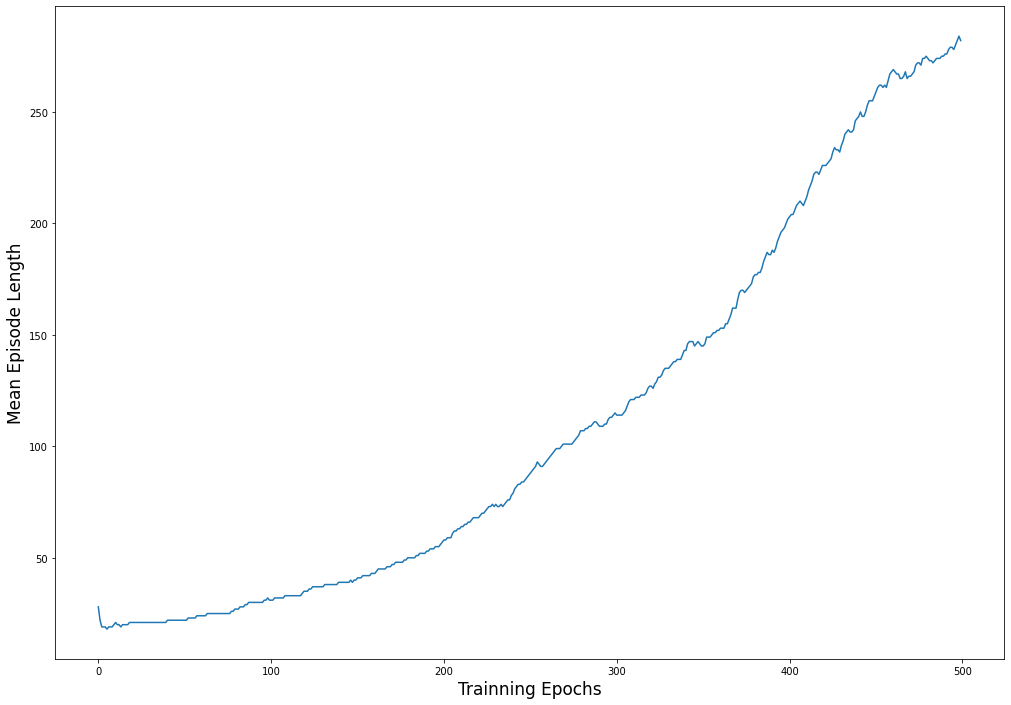

In [14]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

class ActorCritic(nn.Module): # 定義演員評論家模型

  def __init__(self):
    super(ActorCritic,self).__init__()
    self.l1 = nn.Linear(4,25) # 定義模型中各種神經網路的shape
    self.l2 = nn.Linear(25,50)
    self.actor_lin1 = nn.Linear(50,2)
    self.l3 = nn.Linear(50,25)
    self.critic_lin1 = nn.Linear(25,1)
  
  def forward(self,x):
    x = F.normalize(x,dim=0) # 正規化輸入資料
    y = self.l1(x)
    y = F.relu(y)
    y = self.l2(y)
    y = F.relu(y)

    a = self.actor_lin1(y)
    actor = F.log_softmax(a,dim=0) # 演員端輸出遊戲中兩種動作的對數化幾率值

    c = self.l3(y.detach()) # 將評論家端的節點分離，在經過relu的處理
    c = F.relu(c)
    c = self.critic_lin1(c)
    critic = torch.tanh(c) # 評論家端輸出一個範圍在-1到+1之間的純量的原因將在稍後說明

    return actor,critic

def run_episode(worker_env,worker_model):
  state = torch.from_numpy(worker_env.env.state).float() # 將環境的狀態資料從Numpy類型轉化為PyTorch張量
  values,logprobs,rewards = [],[],[] # 建立三個串列，分別用來存儲狀態價值(評論家) 對數化幾率分佈(演員) 以及回饋值
  done = False
  j = 0
  while(done == False): # 除非滿足結束條件，否則遊戲繼續進行
    j += 1 # 記錄執行步數
    policy,value = worker_model(state) # 計算狀態價值以及各種可能動作的對數化幾率
    values.append(value) # 將當前的狀態價值加入列表
    logits = policy.view(-1) # 呼叫view()函式將對數化幾率偏平化成向量
    action_dist = torch.distributions.Categorical(logits=logits) # 创建以参数logits为标准的类别分布
    action = action_dist.sample() # 參考演員所提供的對數化幾率來選擇動作
    logprob_ = policy.view(-1)[action] # 得到所選擇動作的對數化幾率
    logprobs.append(logprob_) # 將所選擇動作的對數化幾率存入列表
    state_,_,done,info = worker_env.step(action.detach().numpy()) # 嘗試執行一下所選擇的動作
    state = torch.from_numpy(state_).float() # 將下一狀態獲取到，並轉化為numpy數組 
    if done : # 如果遊戲結束
      reward = -10 # 如果某一個動作造成遊戲結束，則將回饋值設置為-10，並且重置環境
      worker_env.reset()
    else:
      reward = 1.0 # 如果成功保持倒立擺站立，那麼就加回饋值1
    rewards.append(reward) # 將局部的回饋值添加至列表，用來觀察整體的回饋值變化情況
  return values,logprobs,rewards,len(rewards) # 返回的最後一項是倒立擺保持平衡的時間步數


def update_params(worker_opt,values,logprobs,rewards,clc=0.1,gamma=0.95):
  '''設定一個clc參數來控制演員損失和評論家損失的影響力'''
  rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) # 將rewards陣列中的元素順序顛倒，以方便計算折扣回報值陣列
  logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1) # 將logprobs陣列中的元素順序顛倒，以方便計算折扣回報值陣列
  values = torch.stack(values).flip(dims=(0,)).view(-1) # 將values陣列中的元素順序顛倒，以方便計算折扣回報值陣列

  Returns = []

  ret_ = torch.Tensor([0])
  for r in range(rewards.shape[0]): # 使用順序顛倒的回饋值來計算每一步的回報值，並將結果存入Returns陣列中
    ret_ = rewards[r] + gamma*ret_
    Returns.append(ret_)
  
  Returns = torch.stack(Returns).view(-1)
  Returns = F.normalize(Returns,dim=0) # 將Returns陣列中的製作正規化處理

  actor_loss = -1*logprobs*(Returns - values.detach()) # 將value張量的節點從運算圖中分離(用之前講的detach()),並計算演員的損失

  critic_loss = torch.pow(values-Returns,2) # 計算評論家的損失

  loss = actor_loss.sum() + clc*critic_loss.sum() # 將演員的損失與評論家的損失加起來，變成總損失 注意 我們是用clc參數來降低評論家損失的影響

  loss.backward()
  worker_opt.step()
  return actor_loss,critic_loss,len(rewards)


def worker(t,worker_model,counter,params):
  worker_env = gym.make("CartPole-v1")
  worker_env.reset()
  worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters()) # 每條程序有獨立運行的環境和優化器，但共享模型參數
  worker_opt.zero_grad()

  for i in range(params["epochs"]):
    worker_opt.zero_grad()
    values,logprobs,rewards,length = run_episode(worker_env,worker_model) # 呼叫run_episode()來執行一場遊戲並收集資料(該函式的定義見5.7)
    actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards) # 使用所收集的資料來更新神經網路參數(該函式的定義見5.8)
    
    counter.value = counter.value + 1 # counter是一個全域計數器，被所有程序共享

    if (i%10==0): # 印出當前的訓練進度
      print(i)
      print(len(rewards))
      clear_output(wait=True)
    
    buffer.put(length) # 將遊戲的長度存進buffer中


if __name__ == '__main__':

  MasterNode = ActorCritic() # 建立一個共享全域的演員-評論家模型
  MasterNode.share_memory() # share_memory()允許不同程序共用一組模型參數(無需複製模型節省空間)

  processes = [] # 用來存儲不同程序的實例
  params = {
      'epochs':500, # 進行500次訓練
      'n_workers':7 # 設定程序數目為7
  }

  counter = mp.Value('i',0) # 使用multiproccesing函式庫創建一個全域計數器，參數'i'代表其資料型別為整數
  
  buffer = mp.Queue() # 用於記錄每場遊戲的長度

  for i in range(params['n_workers']):
    p = mp.Process(target=worker,args=(i,MasterNode,counter,params)) # 啟動新的程序來運行worker函式(該韓式的定義見5.6)
    p.start()
    processes.append(p)
  for p in processes:
    p.join() # 利用join讓每條程序完乘運算後，再將結果傳回
  for p in processes:
    p.terminate() # 終止各個程序

  # 畫出平均遊戲長度
  n = params["n_workers"]
  score = []
  running_mean = []
  total = torch.Tensor([0])
  mean = torch.Tensor([0])
  while not buffer.empty():
    score.append(buffer.get()) # 將buffer中的資料存入score
  print(len(score))
  for i in range(params['epochs']):
    if (i>=50):
      total = total - sum(score[n*(i-50):n*(i-50)+n])/n
      total = total + sum(score[n*i:n*i+n])/n
      mean = int(total/50)
    else:
      total = total + sum(score[n*i:n*i+n])/n
      mean = int(total/(i+1))
    running_mean.append(mean)
  plt.figure(figsize=(17,12))
  plt.ylabel("Mean Episode Length",fontsize=17)
  plt.xlabel("Trainning Epochs",fontsize=17)
  plt.plot(np.array(running_mean))
  plt.show()

5.9 N步 演员-评论家算法

In [15]:
# class ActorCritic(nn.Module): # 定義演員評論家模型

#   def __init__(self):
#     super(ActorCritic,self).__init__()
#     self.l1 = nn.Linear(4,25) # 定義模型中各種神經網路的shape
#     self.l2 = nn.Linear(25,50)
#     self.actor_lin1 = nn.Linear(50,2)
#     self.l3 = nn.Linear(50,25)
#     self.critic_lin1 = nn.Linear(25,1)
  
#   def forward(self,x):
#     x = F.normalize(x,dim=0) # 正規化輸入資料
#     y = self.l1(x)
#     y = F.relu(y)
#     y = self.l2(y)
#     y = F.relu(y)

#     a = self.actor_lin1(y)
#     actor = F.log_softmax(a,dim=0) # 演員端輸出遊戲中兩種動作的對數化幾率值

#     c = self.l3(y.detach()) # 將評論家端的節點分離，在經過relu的處理
#     c = F.relu(c)
#     c = self.critic_lin1(c)
#     critic = torch.tanh(c) # 評論家端輸出一個範圍在-1到+1之間的純量的原因將在稍後說明

#     return actor,critic

In [16]:
# def update_params(worker_opt,values,logprobs,rewards,G,clc=0.1,gamma=0.95):
#   rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)
#   logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
#   values = torch.stack(values).flip(dims=(0,)).view(-1)
#   Returns = []
#   ret_ = G # 使用G來代替原本的torch.Tensor([0])
#   for r in range(rewards.shape[0]):
#     ret_ = rewards[r] + gamma * ret_
#     Returns.append(ret_)
#   Returns = torch.stack(Returns).view(-1)
#   Returns = F.normalize(Returns,dim=0)
#   actor_loss = -1*logprobs*(Returns-values.detach())
#   critic_loss = torch.pow(values-Returns,2)
#   loss = actor_loss.sum() + clc*critic_loss.sum()
#   loss.backward()
#   worker_opt.step()
#   return actor_loss,critic_loss,len(rewards)

In [17]:
# def run_episode(worker_env,worker_model,N_steps=100):
#   raw_state = np.array(worker_env.env.state)
#   state = torch.from_numpy(raw_state).float()
#   values,logprobs,rewards = [],[],[]
#   done = False
#   j = 0
#   check = 1
#   G = torch.Tensor([0]) # 變數G代表回報值，有它的初始值為0
#   while(j<N_steps and done == False): # 持續進行遊戲，直到經過了N步或者遊戲結束
#     j += 1
#     policy,value = worker_model(state)
#     values.append(value)
#     logits = policy.view(-1)
#     action_dist = torch.distributions.Categorical(logits=logits)
#     action = action_dist.sample()
#     logprob_ = policy.view(-1)[action]
#     logprobs.append(logprob_)
#     state_,_,done,info = worker_env.step(action.detach().numpy())
#     state = torch.from_numpy(state_).float()
#     if done:
#       reward = -10
#       worker_env.reset()
#       check = 1
#     else: # 若遊戲並未結束，令回報值等於最新的狀態價值
#       reward = 1.0
#       G = value.detach()
#       check = 0
#     rewards.append(reward)
#   return values,logprobs,rewards,G,check

In [18]:
# def worker(t,worker_model,counter,params,buffer):
#   worker_env = gym.make("CartPole-v1")
#   worker_env.reset()
#   worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters())
#   worker_opt.zero_grad()
#   tot_rew = torch.Tensor([0])
#   for i in range(params['epochs']):
#     worker_opt.zero_grad()
#     values, logprobs, rewards, G, check = run_episode(worker_env,worker_model)
#     actor_loss,critic_loss,tot_rew = update_params(worker_opt,values,logprobs,rewards,G)
#     while(check == 0):
#       worker_opt.zero_grad()
#       values, logprobs, rewards, G, check = run_episode(worker_env,worker_model)
#       actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards,G)
#       tot_rew += eplen
#     counter.value = counter.value + 1
#     if (i%10 == 0):
#       print(i)
#       print(tot_rew)
#       clear_output(wait=True)
#     buffer.put(tot_rew)

In [19]:
# if __name__ == '__main__':

#   MasterNode = ActorCritic() # 建立一個共享全域的演員-評論家模型
#   MasterNode.share_memory() # share_memory()允許不同程序共用一組模型參數(無需複製模型節省空間)

#   processes = [] # 用來存儲不同程序的實例
#   params = {
#       'epochs':500, # 進行500次訓練
#       'n_workers':7 # 設定程序數目為7
#   }

#   counter = mp.Value('i',0) # 使用multiproccesing函式庫創建一個全域計數器，參數'i'代表其資料型別為整數
  
#   buffer = mp.Queue() # 用於記錄每場遊戲的長度

#   for i in range(params['n_workers']):
#     p = mp.Process(target=worker,args=(i,MasterNode,counter,params,buffer)) # 啟動新的程序來運行worker函式(該韓式的定義見5.6)
#     p.start()
#     processes.append(p)
#   for p in processes:
#     p.join() # 利用join讓每條程序完乘運算後，再將結果傳回
#   for p in processes:
#     p.terminate() # 終止各個程序

#   # 畫出平均遊戲長度
#   n = params["n_workers"]
#   score = []
#   running_mean = []
#   total = torch.Tensor([0])
#   mean = torch.Tensor([0])
#   while not buffer.empty():
#     score.append(buffer.get()) # 將buffer中的資料存入score
#   print(len(score))
#   for i in range(params['epochs']):
#     if (i>=50):
#       total = total - sum(score[n*(i-50):n*(i-50)+n])/n
#       total = total + sum(score[n*i:n*i+n])/n
#       mean = int(total/50)
#     else:
#       total = total + sum(score[n*i:n*i+n])/n
#       mean = int(total/(i+1))
#     running_mean.append(mean)
#   plt.figure(figsize=(17,12))
#   plt.ylabel("Mean Episode Length",fontsize=17)
#   plt.xlabel("Trainning Epochs",fontsize=17)
#   plt.plot(np.array(running_mean))
#   plt.show()

將上面的內容集中到一個單元格里面

3500


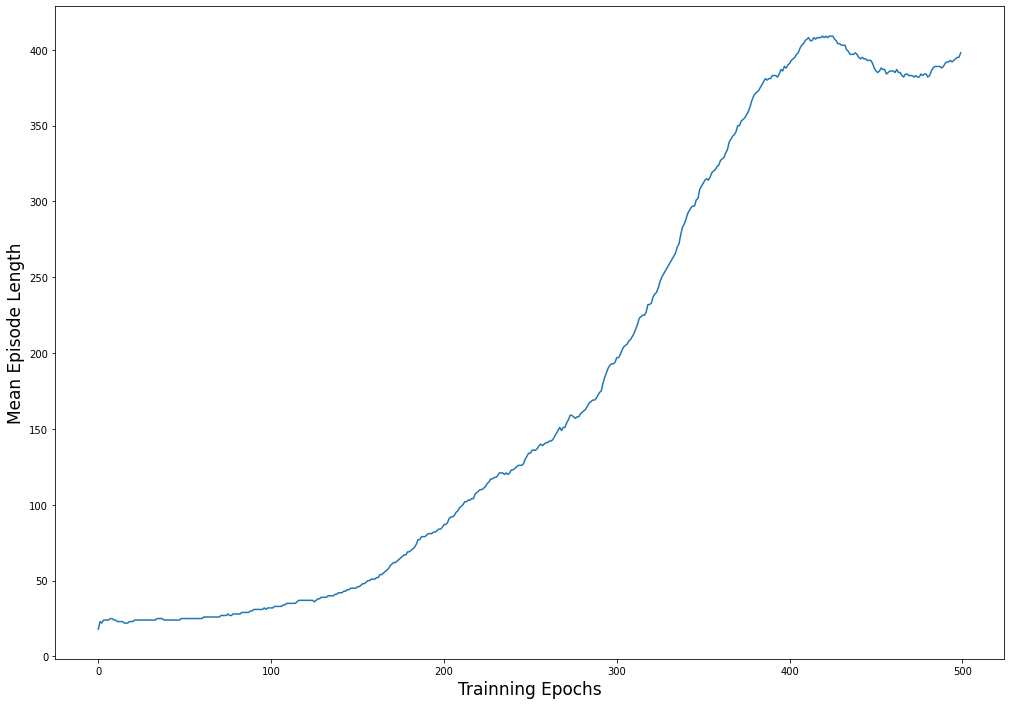

In [20]:
class ActorCritic(nn.Module): # 定義演員評論家模型

  def __init__(self):
    super(ActorCritic,self).__init__()
    self.l1 = nn.Linear(4,25) # 定義模型中各種神經網路的shape
    self.l2 = nn.Linear(25,50)
    self.actor_lin1 = nn.Linear(50,2)
    self.l3 = nn.Linear(50,25)
    self.critic_lin1 = nn.Linear(25,1)
  
  def forward(self,x):
    x = F.normalize(x,dim=0) # 正規化輸入資料
    y = self.l1(x)
    y = F.relu(y)
    y = self.l2(y)
    y = F.relu(y)

    a = self.actor_lin1(y)
    actor = F.log_softmax(a,dim=0) # 演員端輸出遊戲中兩種動作的對數化幾率值

    c = self.l3(y.detach()) # 將評論家端的節點分離，在經過relu的處理
    c = F.relu(c)
    c = self.critic_lin1(c)
    critic = torch.tanh(c) # 評論家端輸出一個範圍在-1到+1之間的純量的原因將在稍後說明

    return actor,critic

def update_params(worker_opt,values,logprobs,rewards,G,clc=0.1,gamma=0.95):
  rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)
  logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
  values = torch.stack(values).flip(dims=(0,)).view(-1)
  Returns = []
  ret_ = G # 使用G來代替原本的torch.Tensor([0])
  for r in range(rewards.shape[0]):
    ret_ = rewards[r] + gamma * ret_
    Returns.append(ret_)
  Returns = torch.stack(Returns).view(-1)
  Returns = F.normalize(Returns,dim=0)
  actor_loss = -1*logprobs*(Returns-values.detach())
  critic_loss = torch.pow(values-Returns,2)
  loss = actor_loss.sum() + clc*critic_loss.sum()
  loss.backward()
  worker_opt.step()
  return actor_loss,critic_loss,len(rewards)

def run_episode(worker_env,worker_model,N_steps=100):
  raw_state = np.array(worker_env.env.state)
  state = torch.from_numpy(raw_state).float()
  values,logprobs,rewards = [],[],[]
  done = False
  j = 0
  check = 1
  G = torch.Tensor([0]) # 變數G代表回報值，有它的初始值為0
  while(j<N_steps and done == False): # 持續進行遊戲，直到經過了N步或者遊戲結束
    j += 1
    policy,value = worker_model(state)
    values.append(value)
    logits = policy.view(-1)
    action_dist = torch.distributions.Categorical(logits=logits)
    action = action_dist.sample()
    logprob_ = policy.view(-1)[action]
    logprobs.append(logprob_)
    state_,_,done,info = worker_env.step(action.detach().numpy())
    state = torch.from_numpy(state_).float()
    if done:
      reward = -10
      worker_env.reset()
      check = 1
    else: # 若遊戲並未結束，令回報值等於最新的狀態價值
      reward = 1.0
      G = value.detach()
      check = 0
    rewards.append(reward)
  return values,logprobs,rewards,G,check


def worker(t,worker_model,counter,params,buffer):
  worker_env = gym.make("CartPole-v1")
  worker_env.reset()
  worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters())
  worker_opt.zero_grad()
  tot_rew = torch.Tensor([0])
  for i in range(params['epochs']):
    worker_opt.zero_grad()
    values, logprobs, rewards, G, check = run_episode(worker_env,worker_model)
    actor_loss,critic_loss,tot_rew = update_params(worker_opt,values,logprobs,rewards,G)
    while(check == 0):
      worker_opt.zero_grad()
      values, logprobs, rewards, G, check = run_episode(worker_env,worker_model)
      actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards,G)
      tot_rew += eplen
    counter.value = counter.value + 1
    if (i%10 == 0):
      print(i)
      print(tot_rew)
      clear_output(wait=True)
    buffer.put(tot_rew)


if __name__ == '__main__':

  MasterNode = ActorCritic() # 建立一個共享全域的演員-評論家模型
  MasterNode.share_memory() # share_memory()允許不同程序共用一組模型參數(無需複製模型節省空間)

  processes = [] # 用來存儲不同程序的實例
  params = {
      'epochs':500, # 進行500次訓練
      'n_workers':7 # 設定程序數目為7
  }

  counter = mp.Value('i',0) # 使用multiproccesing函式庫創建一個全域計數器，參數'i'代表其資料型別為整數
  
  buffer = mp.Queue() # 用於記錄每場遊戲的長度

  for i in range(params['n_workers']):
    p = mp.Process(target=worker,args=(i,MasterNode,counter,params,buffer)) # 啟動新的程序來運行worker函式(該韓式的定義見5.6)
    p.start()
    processes.append(p)
  for p in processes:
    p.join() # 利用join讓每條程序完乘運算後，再將結果傳回
  for p in processes:
    p.terminate() # 終止各個程序

  # 畫出平均遊戲長度
  n = params["n_workers"]
  score = []
  running_mean = []
  total = torch.Tensor([0])
  mean = torch.Tensor([0])
  while not buffer.empty():
    score.append(buffer.get()) # 將buffer中的資料存入score
  print(len(score))
  for i in range(params['epochs']):
    if (i>=50):
      total = total - sum(score[n*(i-50):n*(i-50)+n])/n
      total = total + sum(score[n*i:n*i+n])/n
      mean = int(total/50)
    else:
      total = total + sum(score[n*i:n*i+n])/n
      mean = int(total/(i+1))
    running_mean.append(mean)
  plt.figure(figsize=(17,12))
  plt.ylabel("Mean Episode Length",fontsize=17)
  plt.xlabel("Trainning Epochs",fontsize=17)
  plt.plot(np.array(running_mean))
  plt.show()